# Imports

In [15]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pickle
from scipy.spatial import distance
from itertools import product

# Testing on one frame

## Video indices

In [16]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]


## Functions:
- get_file_path
- extract_landmarks
- draw_landmarks_on_image

In [17]:
# function to get the file path, according to the label, up_down and video_index
def get_file_path(label, up_down, video_index):

    if label == 'correct':
        image_dir = 'images/correct_seq'
        corr_inc = 'cor'
    elif label == 'incorrect':
        image_dir = 'images/wrong_seq'
        corr_inc = 'inc'
    else:
        print('Label not found')
        exit()

    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # In case there is more than one
    if len(matching_files) > 1:
        print('More than one file found')
        exit()
    # But, there should be only one
    file_path = matching_files[0]
    
    return file_path 

In [18]:
# function to get the landmarks from a frame
def extract_landmarks(this_image_path, model_path='pose_landmarker_heavy.task'):

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image = mp.Image.create_from_file(this_image_path)

        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to get the landmarks.
        pose_landmarks = None
        if pose_landmarks_list:
            pose_landmarks = pose_landmarks_list[0]

    return pose_landmarks, pose_landmarker_result

In [19]:
# function to display the landmarks on top of the image
def draw_landmarks_on_image(rgb_image, detection_result, exclude_numbers=[]):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2)
        )

        # Draw landmark numbers on the image.
        for i, landmark in enumerate(pose_landmarks):
            if i not in exclude_numbers:  # only number the landmark if it's not in the exclusion list
                cv2.putText(annotated_image, str(i), (int(landmark.x * rgb_image.shape[1]), int(landmark.y * rgb_image.shape[0])),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return annotated_image

In [20]:
# using the get_file_path and extract_landmarks functions
image_path = get_file_path('correct', 'up', video_index_corr[1])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

# this is how we can access the landmarks coordinates
pose_landmarks[0]


NormalizedLandmark(x=0.7530348300933838, y=0.6043741106987, z=-0.0010913939913734794, visibility=0.9996840953826904, presence=0.9998422861099243)

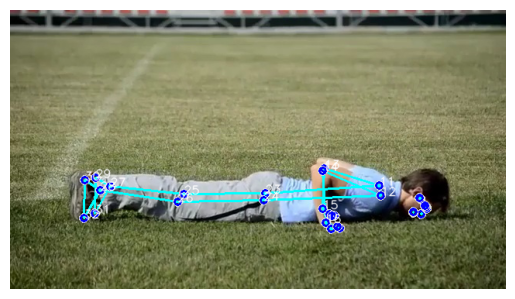

In [21]:
image_path = get_file_path('correct', 'down', video_index_corr[20])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
annotated_image = draw_landmarks_on_image(image, pose_landmarker_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22])
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis
plt.show()



## Functions:
- center_landmarks (on one point, on centroid and on the average of two points)
- draw_landmarks_on_blank_canvas

In [22]:
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose a specific landmark to be the center (e.g., landmark #0)
    center_landmark_index = 24

    # Translate the landmarks so that the center landmark is at (0.5, 0.5)
    centered_landmarks = landmarks_array - landmarks_array[center_landmark_index] + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# center_landmarks, but with centroid
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array, axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# instead, center_landmarks with the mean point of 2 landmarks
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose two specific landmarks to be the center (e.g., landmark #0 and #1)
    center_landmark_indices = [23, 24]

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array[center_landmark_indices], axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks


In [23]:
def draw_landmarks_on_blank_canvas(landmarks, image_size=500, circle_radius=5, line_width=1):
    # Create a blank canvas
    canvas = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

    # Create landmark list protobuf from landmarks
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in landmarks
    ])

    # Draw landmarks on the canvas
    mp.solutions.drawing_utils.draw_landmarks(
        canvas,
        pose_landmarks_proto,
        mp.solutions.pose.POSE_CONNECTIONS,
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=circle_radius),
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=line_width, circle_radius=2)
    )

    

    return canvas

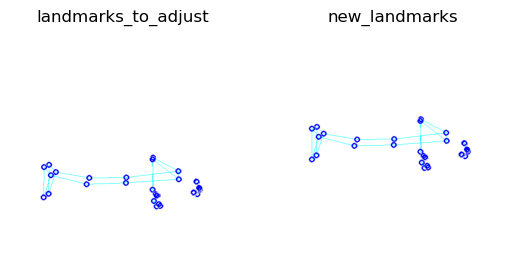

In [24]:
# Display landmarks_adjusted
canvas_adjusted = draw_landmarks_on_blank_canvas(pose_landmarks)
plt.subplot(1, 2, 1)
plt.imshow(canvas_adjusted)
plt.title('landmarks_to_adjust')
plt.axis('off')

new_landmarks = center_landmarks(pose_landmarks)

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(new_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(canvas_new)
plt.title('new_landmarks')
plt.axis('off')

plt.show()

## Function:
- normalize_landmarks

In [25]:
def normalize_landmarks(landmarks_tba, landmarks_rot, connections):
    # Convert landmarks to numpy arrays for easier manipulation
    landmarks_tba_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_tba])
    landmarks_rot_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_rot])

    # Copy landmarks_tba_array to new_landmarks
    new_landmarks = np.copy(landmarks_tba_array)

    # Create an array to keep track of which landmarks have been updated
    updated_landmarks = [False]*len(landmarks_tba)

    # For each connection, adjust the length of the line segment in landmarks_tba to match that in landmarks_rot
    for conn in connections:
        start, end = conn
        # Use updated coordinates for the start point if available
        start_point = new_landmarks[start] if updated_landmarks[start] else landmarks_tba_array[start]

        # Calculate the vector for the line segment in landmarks_tba using original coordinates
        vec_tba = landmarks_tba_array[end] - landmarks_tba_array[start]

        # Calculate the length of the line segment in landmarks_rot
        length_rot = np.linalg.norm(landmarks_rot_array[end] - landmarks_rot_array[start])

        # Compute the direction of the line segment in landmarks_tba
        direction_tba = vec_tba / np.linalg.norm(vec_tba)

        # Compute the end point of the new line segment
        new_landmarks[end] = start_point + direction_tba * length_rot

        # Mark the end landmark as updated
        updated_landmarks[end] = True

    # Convert new_landmarks back to the list of landmark_pb2.NormalizedLandmark
    new_landmarks_pb = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in new_landmarks]

    return new_landmarks_pb


In [26]:
# connections, i.e. order by which we will normalize the landmarks
connections = [
    (23, 24), (23, 11), (24, 12), 
    (11, 13), (12, 14), (13, 15), 
    (14, 16), (15, 17), (16, 18),
    (15, 19), (16, 20), (15, 21),
    (16, 22), (23, 25), (24, 26), 
    (25, 27), (26, 28), (27, 29),
    (28, 30), (27, 31), (28, 32), 
    (11, 0), (12, 0), (0, 1),
    (0, 4), (1, 2), (2, 3),
    (4, 5), (5, 6), (0, 7),
    (0, 8), (2, 7), (5, 8),
    (0, 9), (0, 10)
]


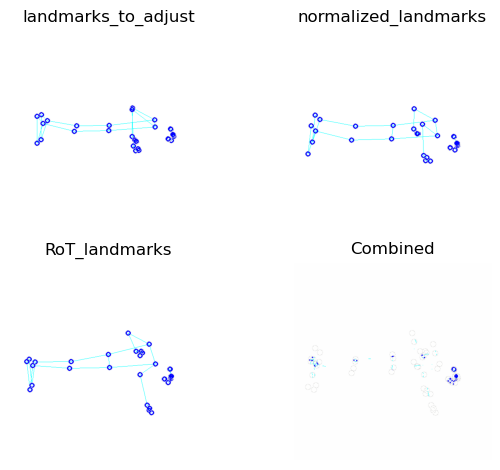

In [27]:
# checking the results of the normalization

# Get the landmarks for the RoT image
RoT_image_path = get_file_path('correct', 'down', video_index_corr[1])
RoT_pose_landmarks, RoT_pose_landmarker_result = extract_landmarks(RoT_image_path)
RoT_landmarks = center_landmarks(RoT_pose_landmarks)

# Get the landmarks for the image to adjust
to_adjust_image_path = get_file_path('correct', 'down', video_index_corr[20])
to_adjust_pose_landmarks, to_adjust_pose_landmarker_result = extract_landmarks(to_adjust_image_path)
to_adjust_landmarks = center_landmarks(to_adjust_pose_landmarks)

# Normalize the landmarks
normalized_landmarks = normalize_landmarks(to_adjust_landmarks, RoT_landmarks, connections)

# Display landmarks_to_adjust
canvas_to_adjust = draw_landmarks_on_blank_canvas(to_adjust_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 1)
plt.imshow(canvas_to_adjust)
plt.title('landmarks_to_adjust')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(normalized_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 2)
plt.imshow(canvas_new)
plt.title('normalized_landmarks')
plt.axis('off')


# Display the RoT landmarks
canvas_RoT = draw_landmarks_on_blank_canvas(RoT_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 3)
plt.imshow(canvas_RoT)
plt.title('RoT_landmarks')
plt.axis('off')

# Display both new_landmarks and RoT_landmarks on top of each other, with connections
canvas_combined = canvas_new + canvas_RoT  # Add both canvases together
plt.subplot(2, 2, 4)
plt.imshow(canvas_combined)
plt.title('Combined')
plt.axis('off')




plt.tight_layout()
plt.show()


# Now working on all images

## Video indices

In [28]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 153, 155, 156, 166, 167, 168, 171, 198] # took out 152, mediapipe couldn't find landmarks, idky


## Computing average landmarks 
(avg_corr/incorr_up/down)

In [29]:
'''
# Establishing which frame position we want, manually.
up_down = 'up'  # 'up' or 'down'

# Establishing which label we want, manually.
label = 'correct'  # 'correct' or 'incorrect'

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

# Prepare variables to store sum of landmarks and count of images
list_landmarks = []

for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    # Get landmarks from image
    landmarks = extract_landmarks(file_path)[0]
    # Convert landmarks to numpy array for easier manipulation
    landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])

    # Add landmarks array to list
    list_landmarks.append(landmarks_array)

# Convert list of landmarks to numpy array
list_landmarks_array = np.array(list_landmarks)

# Calculate average landmarks
avg_landmarks_array = np.mean(list_landmarks_array, axis=0)

# Calculate standard deviation of landmarks
std_landmarks_array = np.std(list_landmarks_array, axis=0)

# Convert average_landmarks back to the list of landmark_pb2.NormalizedLandmark
avg_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks_array]

'''

"\n# Establishing which frame position we want, manually.\nup_down = 'up'  # 'up' or 'down'\n\n# Establishing which label we want, manually.\nlabel = 'correct'  # 'correct' or 'incorrect'\n\nif label == 'correct':\n    video_indices = video_index_corr\nelif label == 'incorrect':\n    video_indices = video_index_incorr\nelse:\n    print('Label not found')\n    exit()\n\n# Prepare variables to store sum of landmarks and count of images\nlist_landmarks = []\n\nfor video_index in video_indices:\n    file_path = get_file_path(label, up_down, video_index)\n    # Get landmarks from image\n    landmarks = extract_landmarks(file_path)[0]\n    # Convert landmarks to numpy array for easier manipulation\n    landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])\n\n    # Add landmarks array to list\n    list_landmarks.append(landmarks_array)\n\n# Convert list of landmarks to numpy array\nlist_landmarks_array = np.array(list_landmarks)\n\n# Calculate average la

In [30]:
'''
# Importing the average landmarks with pickle (and std_dev)

# define a filename to save the data
filename = 'avg_landmarks_C_U.pkl'

# open the file in write binary mode
with open(filename, 'wb') as f:
    # dump the avg_landmarks object into the file
    pickle.dump(avg_landmarks, f)
    pickle.dump(std_landmarks_array, f)

'''

"\n# Importing the average landmarks with pickle (and std_dev)\n\n# define a filename to save the data\nfilename = 'avg_landmarks_C_U.pkl'\n\n# open the file in write binary mode\nwith open(filename, 'wb') as f:\n    # dump the avg_landmarks object into the file\n    pickle.dump(avg_landmarks, f)\n    pickle.dump(std_landmarks_array, f)\n\n"

In [31]:
# opening the average landmarks file

#filename = 'avg_landmarks_C_U.pkl'
#filename = 'avg_landmarks_C_D.pkl'
#filename = 'avg_landmarks_I_U.pkl'
filename = 'avg_landmarks_I_D.pkl'

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)


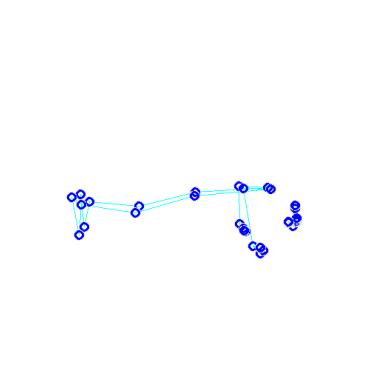

In [32]:
# displaying the average landmarks
avg_landmarks = center_landmarks(avg_landmarks)
canvas_avg = draw_landmarks_on_blank_canvas(avg_landmarks)
plt.imshow(canvas_avg)
plt.axis('off')
plt.show()

## Euclidean distance classifier

In [71]:
# preparing variables for classification

label = 'incorrect' # 'correct' or 'incorrect'

# we pick this one or the one below
filename = 'avg_landmarks_C_U.pkl' # up
#filename = 'avg_landmarks_C_D.pkl' # down

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)

if filename == 'avg_landmarks_C_U.pkl':
    up_down = 'up'
elif filename == 'avg_landmarks_C_D.pkl':
    up_down = 'down'
else:
    print('File name not found')
    exit()

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

In [72]:
# distance classifier
def classify_pushup(new_landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha):
    # Convert new_landmarks to numpy array for easier manipulation
    new_landmarks_array = np.array([[landmark.x, landmark.y] for landmark in new_landmarks])

    # instead of only for on landmark_indices, also include a counter
    for counter,i in enumerate(landmark_indices):
        # Calculate Euclidean distance between new and average landmarks
        dist = distance.euclidean(new_landmarks_array[i], [avg_landmarks[i].x, avg_landmarks[i].y])

        # Get the larger of the std deviations for x and y for this landmark
        max_std = alpha[counter]*max(std_landmarks[i][0], std_landmarks[i][1])

        # If distance exceeds the threshold, classify as incorrect
        if dist > max_std:
            return f'Incorrect (landmark {i} deviated by {dist})'

    # If all landmarks are within the threshold, classify as correct
    return 'Correct'


In [73]:
# Prepare accuracy counter
correct_count = 0


for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    # Get landmarks from image
    landmarks = extract_landmarks(file_path)[0]

    # Center and normalize landmarks
    landmarks = center_landmarks(landmarks)
    landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)

    # Classify pushup
    landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head
    #landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head
    if up_down == 'up':
        alpha = 3.0  # Std coefficient
    elif up_down == 'down':
        alpha = 3.0  # Std coefficient
    else:
        print('Up/down not found')
        exit()


    # 98 <-> 80 , up 
    # 48 <-> 10 , up
    alpha = [3.7430316514136974, 2.5631452907885115, 4.611076277590342, 3.0818221510172092, 4.996586693693493, 2.890326651133698, 3.951352209434625, 2.2430705535327427, 3.9453426453536893, 4.967330662797752, 3.1795596051878565, 2.839463780070391, 3.918809088168116] 
    alpha = [4.5460081660929585, 4.965319319817605, 2.92307238408907, 3.903935003278389, 4.303829455353251, 1.0694625873069996, 4.228307756512304, 1.0716948826311627, 4.0471057324988395, 3.6396060971267334, 2.4241278962112536, 2.153548606454849, 2.2513511892633598]
    classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices,alpha)

    # Accuracy
    if classification == 'Correct':
        correct_count += 1


# Print accuracy
print(f'Accuracy: {correct_count/len(video_indices)*100:.2f}% for {label} {up_down} pushups, alpha={alpha}')

Accuracy: 10.20% for incorrect up pushups, alpha=[4.5460081660929585, 4.965319319817605, 2.92307238408907, 3.903935003278389, 4.303829455353251, 1.0694625873069996, 4.228307756512304, 1.0716948826311627, 4.0471057324988395, 3.6396060971267334, 2.4241278962112536, 2.153548606454849, 2.2513511892633598]


In [65]:
# Define possible alpha values and initialize variables
alpha_values = np.arange(3.0, 3.01, 0.1)
best_alpha = None
best_accuracy = 0


# Loop over all possible alpha values
for alpha in alpha_values:
    
    # Prepare accuracy counter
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, np.zeros(13) + alpha)

        if classification == 'Correct':
            correct_count += 1

    # Calculate and print accuracy for this alpha value
    accuracy = correct_count / len(video_indices)
    print(f'Alpha: {alpha:.1f}, Accuracy: {accuracy * 100:.2f}%')

    # If this accuracy is the best so far, store alpha and accuracy
    if accuracy > best_accuracy:
        best_alpha = alpha
        best_accuracy = accuracy

# Print best alpha value and corresponding accuracy
print(f'Best alpha: {best_alpha:.1f}, Best accuracy: {best_accuracy * 100:.2f}%')

Alpha: 3.0, Accuracy: 62.00%
Best alpha: 3.0, Best accuracy: 62.00%


In [64]:
alpha

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [ ]:
exit()

In [ ]:
"""
# Define possible alpha values
alpha_values = np.arange(1.0, 5.0, 1.0)

# Generate all combinations of alpha values for two landmarks
alpha_combinations = list(product(alpha_values, repeat=len(landmark_indices)))

best_alpha_combination = None
best_accuracy = 0

# Loop over all combinations of alpha values
for alpha_combination in alpha_combinations:

    # Prepare accuracy counter
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha_combination)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    
    # If this accuracy is the best so far, store alpha and accuracy
    if accuracy > best_accuracy:
        best_alpha_combination = alpha_combination
        best_accuracy = accuracy
        
    print(f'Current alpha: {alpha}, current best alpha: {best_alpha_combination}, Current best accuracy: {best_accuracy * 100:.2f}%, iteration {alpha_combinations.index(alpha_combination)} of {len(alpha_combinations)}', end='\r')


# Print best alpha value and corresponding accuracy
print(f'Best alpha: {best_alpha_combination}, Best accuracy: {best_accuracy * 100:.2f}%')

"""

"\nimport numpy as np\nfrom itertools import product\n\n# Define possible alpha values\nalpha_values = np.arange(1.0, 5.0, 1.0)\n\n# Generate all combinations of alpha values for two landmarks\nalpha_combinations = list(product(alpha_values, repeat=len(landmark_indices)))\n\nbest_alpha_combination = None\nbest_accuracy = 0\n\n# Loop over all combinations of alpha values\nfor alpha_combination in alpha_combinations:\n\n    # Prepare accuracy counter\n    correct_count = 0\n\n    for video_index in video_indices:\n        file_path = get_file_path(label, up_down, video_index)\n        landmarks = extract_landmarks(file_path)[0]\n        landmarks = center_landmarks(landmarks)\n        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)\n        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]\n        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha_combination)\n\n        if classification == 'Correct':

In [69]:
import random
from deap import base, creator, tools, algorithms

landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head
population_size = 10 # 50
n_generations = 5 # 40
alpha_min = 1.0
alpha_max = 2.0

# create classes for fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax, n=len(landmark_indices))

toolbox = base.Toolbox()

# define alpha values for each individual (13 landmarks)
toolbox.register("attr_alpha", random.uniform, 1.0, 5.0)  # adjust as needed

# define the individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# define the fitness function
def evalPushupAccuracy(individual):
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, individual)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)
    
    return (accuracy,)

# set up the evaluation, selection, crossover, and mutation operators
toolbox.register("evaluate", evalPushupAccuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=alpha_min, up=alpha_max, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# setting up statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

def main():
    pop = toolbox.population(n=population_size)  # you may adjust the population size as needed
    hof = tools.HallOfFame(1)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, stats=stats, halloffame=hof, verbose=True)  # adjust parameters as needed

    return pop, logbook, hof

if __name__ == "__main__":
    population, log, hof = main()
    print(f'Best individual: {hof[0]}, Best accuracy: {hof[0].fitness.values[0] * 100:.2f}%')


/home/caria/anaconda3/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg  	min	max 
0  	10    	0.074	0  	0.46
1  	6     	0.13 	0  	0.46
2  	5     	0.246	0.02	0.48
3  	6     	0.372	0.14	0.48
4  	6     	0.476	0.46	0.48
5  	7     	0.48 	0.48	0.48
Best individual: [4.5460081660929585, 4.965319319817605, 2.92307238408907, 3.903935003278389, 4.303829455353251, 1.0694625873069996, 4.228307756512304, 1.0716948826311627, 4.0471057324988395, 3.6396060971267334, 2.4241278962112536, 2.153548606454849, 2.2513511892633598], Best accuracy: 48.00%


In [68]:
import random
from deap import base, creator, tools, algorithms

landmark_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]  # U&L body, head
population_size = 5
n_generations = 3

# create classes for fitness and individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin, n=len(landmark_indices))

toolbox = base.Toolbox()

# define alpha values for each individual (13 landmarks)
toolbox.register("attr_alpha", random.uniform, 1.0, 5.0)  # adjust as needed

# define the individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# define the fitness function
def evalPushupAccuracy(individual):
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, individual)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    return (accuracy,)

# set up the evaluation, selection, crossover, and mutation operators
toolbox.register("evaluate", evalPushupAccuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# setting up statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

def main():
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof

if __name__ == "__main__":
    population, log, hof = main()
    best_alpha = min(hof[0])
    print(f"Best alpha: {best_alpha}, Best accuracy: {hof[0].fitness.values[0] * 100:.2f}%")


gen	nevals	avg  	min	max
0  	5     	0.248	0  	0.6
1  	1     	0    	0  	0  
2  	2     	0    	0  	0  
3  	1     	0    	0  	0  
Best alpha: 1.08708498674111, Best accuracy: 0.00%


In [67]:
import random
from deap import base, creator, tools, algorithms

landmark_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]  # U&L body, head
population_size = 10
n_generations = 3
elite_size = 1  # Number of elite individuals to preserve in each generation

# create classes for fitness and individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin, n=len(landmark_indices))

toolbox = base.Toolbox()

# define alpha values for each individual (13 landmarks)
toolbox.register("attr_alpha", random.uniform, 1.0, 5.0)  # adjust as needed

# define the individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# define the fitness function
def evalPushupAccuracy(individual):
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, individual)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    return (accuracy,)

# set up the evaluation, selection, crossover, and mutation operators
toolbox.register("evaluate", evalPushupAccuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# setting up statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

def main():
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(elite_size)
    
    for gen in range(n_generations):
        # Evaluate the fitness of the entire population
        fitnesses = toolbox.map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop) - elite_size)

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Replace the least fit individuals with the offspring
        pop[elite_size:] = offspring

        # Update the hall of fame with the best individuals
        hof.update(pop)

        # Gather statistics for the current generation
        record = stats.compile(pop)
        print(f"Generation {gen+1}: {record}")

    return pop, hof

if __name__ == "__main__":
    population, hof = main()
    best_alpha = min(hof[0])
    print(f"Best alpha: {best_alpha}, Best accuracy: {hof[0].fitness.values[0] * 100:.2f}%")


/home/caria/anaconda3/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/caria/anaconda3/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/caria/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/caria/anaconda3/lib/p

Generation 1: {'avg': array([0., 0., 0., 0., 0.]), 'min': (), 'max': (0.0,)}
Generation 2: {'avg': array([0., 0., 0., 0., 0., 0., 0.]), 'min': (), 'max': (0.0,)}
Generation 3: {'avg': array([0., 0., 0., 0., 0.]), 'min': (), 'max': (0.0,)}
Best alpha: 1.4971506604431766, Best accuracy: 0.00%


# Code Leonardo

/home/caria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


correct_seq


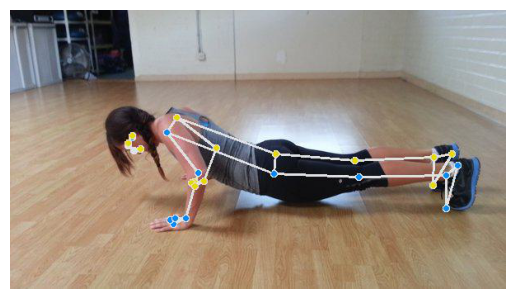

In [62]:
from L_pipeline_cnn import predict_down, predict_up

image_path = 'images_with_landmarks/train/up/correct_seq/cor_up_1_16.jpg' # correct 
image_path = 'images_with_landmarks/test/down/wrong_seq/6_inc.jpg' # wrong
#image_path = 'images_with_landmarks/test/down/correct_seq/2_cor.jpg' # wrong

result = predict_up(image_path)
print(result)

# display the image
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()